In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# Airbnb Data Playbook for Istanbul

This notebook is created to investigate some properties of the Airbnb Istanbul data. This notebook is gonna be a living project with possibly adding new questions and trying to answer them.

**These are the questions that I'm gonna investigate right now:**
- Is it possible to predict the price for a new listing?
- What is the most important feature affecting the price?
- Which ones are the most expensive neighborhoods?

**And, the questions for the future:**
- Seasonal availability ratio for the listings/neighborhoods
- Neighborhoods getting the most reviews
- The most popular neighborhoods (winter & summer, availability)
- How positive is the reviewer?

## Data Preparation

Let's have a look at the columns and check whether we have informative values or not.

In [2]:
listings = pd.read_csv('istanbul/listings.csv', index_col='id')
print(listings.shape)
listings.head(3)

(19727, 105)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (43,61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4826,https://www.airbnb.com/rooms/4826,20190629051244,2019-06-29,The Place,My place is close to great views. My place is ...,A double bed apartment on the Asian side of Is...,My place is close to great views. My place is ...,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/15347/ba87...,NaN,6603,https://www.airbnb.com/users/show/6603,Kaan,2009-01-14,"Istanbul, Istanbul, Turkey","Hello...\r\nI am Kaan and I am from Istanbul, ...",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/6603/profile_...,https://a0.muscache.com/im/users/6603/profile_...,Üsküdar,1.0,1.0,"['email', 'phone', 'facebook', 'reviews']",t,f,"Istanbul Province, Istanbul, Turkey",Üsküdar,Uskudar,NaN,Istanbul Province,Istanbul,34684,Istanbul,"Istanbul Province, Turkey",TR,Turkey,41.05650,29.05367,f,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Smoking ...",700.0,$607.00,NaN,NaN,NaN,NaN,2,$150.00,1,730,1,1,730,730,1.0,730.0,26 months ago,t,30,60,90,365,2019-06-29,1,0,2009-06-01,2009-06-01,100.0,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,f,flexible,f,f,1,1,0,0,0.01
20815,https://www.airbnb.com/rooms/20815,20190629051244,2019-06-29,The Bosphorus from The Comfy Hill,Watch The Bosphorus from The Comfy Hill. A spa...,"The low green hills of Arnavutköy, the lovely,...",Watch The Bosphorus from The Comfy Hill. A spa...,none,"The lovely neighborhood, Arnavutkoy, is locate...",The house may be suited with extra inflatable ...,"The city center, Taksim is about 6-7 kilometer...",Our dear guests may enjoy the oven and the was...,"Depending on our time available, we may even t...",- Windows facing the street should not be left...,NaN,NaN,https://a0.muscache.com/im/pictures/94805791/4...,NaN,78838,https://www.airbnb.com/users/show/78838,Gülder,2010-02-08,"Ankara, Ankara, Turkey",Başar Family\r\n\r\nGülder (mother): Owner of ...,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/78838/profile...,https://a0.muscache.com/im/users/78838/profile...,Beşiktaş,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'wor...",t,f,"Istanbul, Turkey",Beşiktaş,Besiktas,NaN,Istanbul,NaN,34345,Istanbul,"Istanbul, Turkey",TR,Turkey,41.0698

We can drop the columns that have many NaN values, I've defined the threshold as 80%.

In [3]:
nan_columns = listings.columns[listings.isnull().sum() / len(listings) > 0.8 ]
listings.drop(nan_columns,axis=1,inplace=True)
listings.shape

(19727, 95)

In [4]:
listings.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19727 entries, 4826 to 36183972
Data columns (total 95 columns):
listing_url                                     19727 non-null object
scrape_id                                       19727 non-null int64
last_scraped                                    19727 non-null object
name                                            19646 non-null object
summary                                         17389 non-null object
space                                           10779 non-null object
description                                     18240 non-null object
experiences_offered                             19727 non-null object
neighborhood_overview                           9133 non-null object
notes                                           4761 non-null object
transit                                         8526 non-null object
access                                          6925 non-null object
interaction                                     78

Seems like we have many object datatyped columns.  
We need to investigate these columns to understand whether they carry useful information or not.

In [5]:
objects = listings.columns[listings.dtypes == object]
print(objects)
listings[objects].head(1)

Index(['listing_url', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'access', 'interaction', 'house_rules', 'picture_url',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed', 'city', 'state',
       'zipcode', 'market', 'smart_location', 'country_code', 'country',
       'is_location_exact', 'property_type', 'room_type', 'bed_type',
       'amenities', 'price', 'security_deposit', 'cleaning_fee',
       'extra_people', 'calendar_updated', 'has_availability',
       'calendar_last_scraped', 'first_review', 'last_review',
       'requires_license', 'instant_bookable', 'is_business_travel_ready

,listing_url,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,picture_url,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,city,state,zipcode,market,smart_location,country_code,country,is_location_exact,property_type,room_type,bed_type,amenities,price,security_deposit,cleaning_fee,extra_people,calendar_updated,has_availability,calendar_last_scraped,first_review,last_review,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4826,https://www.airbnb.com/rooms/4826,2019-06-29,The Place,My place is close to great views. My place is ...,A double bed apartment on the Asian side of Is...,My place is close to great views. My place is ...,none,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/15347/ba87...,https://www.airbnb.com/users/show/6603,Kaan,2009-01-14,"Istanbul, Istanbul, Turkey","Hello...\r\nI am Kaan and I am from Istanbul, ...",NaN,NaN,f,https://a0.muscache.com/im/users/6603/profile_...,https://a0.muscache.com/im/users/6603/profile_...,Üsküdar,"['email', 'phone', 'facebook', 'reviews']",t,f,"Istanbul Province, Istanbul, Turkey",Üsküdar,Uskudar,Istanbul Province,Istanbul,34684,Istanbul,"Istanbul Province, Turkey",TR,Turkey,f,Apartment,Entire home/apt,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Smoking ...",$607.00,NaN,NaN,$150.00,26 months ago,t,2019-06-29,2009-06-01,2009-06-01,f,f,f,flexible,f,f


We can remove the columns that have same value for the entire dataset.  

In [6]:
listings.is_business_travel_ready.value_counts()

f    19727
Name: is_business_travel_ready, dtype: int64

In [7]:
same_valued_columns = ['is_business_travel_ready', 'country_code','country', 
                       'has_availability', 'calendar_last_scraped','requires_license',
                       'experiences_offered','last_scraped','require_guest_phone_verification',
                       'require_guest_profile_picture','host_has_profile_pic','scrape_id']
listings.drop(same_valued_columns,axis=1,inplace=True)


And, the columns that have inconsistent values.

In [8]:
listings.market.value_counts()

Istanbul                 19553
Other (International)      171
Marmara                      3
Name: market, dtype: int64

In [9]:
inconsistent_valued_columns = ['city', 'state','street','neighbourhood','market']
listings.drop(inconsistent_valued_columns,axis=1,inplace=True)

listings.shape

(19727, 78)

In [10]:
removed_columns = same_valued_columns + inconsistent_valued_columns
objects = list(set(objects) - set(removed_columns))
objects

['room_type',
 'cancellation_policy',
 'notes',
 'host_since',
 'calendar_updated',
 'host_is_superhost',
 'cleaning_fee',
 'amenities',
 'house_rules',
 'transit',
 'host_response_time',
 'listing_url',
 'instant_bookable',
 'price',
 'extra_people',
 'host_thumbnail_url',
 'property_type',
 'host_verifications',
 'neighborhood_overview',
 'picture_url',
 'host_url',
 'interaction',
 'host_neighbourhood',
 'bed_type',
 'space',
 'summary',
 'first_review',
 'access',
 'host_picture_url',
 'neighbourhood_cleansed',
 'host_about',
 'host_response_rate',
 'smart_location',
 'name',
 'is_location_exact',
 'host_name',
 'description',
 'host_location',
 'zipcode',
 'host_identity_verified',
 'security_deposit',
 'last_review']

From the above list we can see that there are some columns with wrong datatypes like `price` which should have numerical datatype.

Some of them doesn't seem useful at all like urls, so we can just drop them. And, some of them might be useful like `notes` and `transit` explanation that people might find necessary info in these parts that affects their decisions. But, for simplicity we can drop them as well.

Some columns definitely need extra analysis and processing.
 

In [11]:
wrong_datatyped = ['cleaning_fee','security_deposit','price','extra_people']
not_useful_columns = ['host_thumbnail_url','picture_url','host_picture_url','host_url','listing_url','host_id']
maybe_useful_columns = ['host_about', 'house_rules', 'summary', 'description', 'name', 'notes', 'transit', 'neighborhood_overview', 'host_name', 'interaction', 'zipcode', 'space', 'host_location', 'access', 'smart_location', 'host_neighbourhood']
boolean_columns = ['host_identity_verified', 'is_location_exact', 'instant_bookable', 'host_is_superhost']
extra_processing = ['host_response_rate', 'property_type', 'calendar_updated', 'host_verifications', 'neighbourhood_cleansed', 'amenities', 'room_type', 'cancellation_policy', 'host_response_time', 'bed_type', 'last_review','host_since','first_review']


In [12]:
listings.drop(not_useful_columns,axis=1,inplace=True)
listings.drop(maybe_useful_columns,axis=1,inplace=True)

listings.shape

(19727, 56)

We can leave `wrong_datatyped` columns for now since these should be numerical columns, and we can deal with numerical processing later.

We can convert `boolean_columns` to numerical columns.

In [13]:
for column in boolean_columns:
    listings[column] = listings[column].apply(lambda x: 1 if x == 't' else 0)

In [14]:
cols_dropped = listings.copy()

And, start investigating `extra_processing` columns.

In [15]:
cols_dropped.host_response_rate.value_counts(normalize=True)

100%    0.670221
0%      0.064205
90%     0.035449
50%     0.023902
80%     0.021034
67%     0.016695
97%     0.014562
70%     0.010958
75%     0.010517
98%     0.009267
83%     0.009120
60%     0.009046
33%     0.008825
86%     0.007722
88%     0.006987
96%     0.006693
95%     0.006546
89%     0.006325
99%     0.006031
91%     0.005957
94%     0.004413
40%     0.004339
93%     0.004119
71%     0.003236
25%     0.003236
92%     0.002942
78%     0.002059
81%     0.001912
20%     0.001618
52%     0.001618
87%     0.001544
84%     0.001397
85%     0.001324
57%     0.001177
56%     0.001177
30%     0.001103
73%     0.001030
38%     0.000956
63%     0.000956
43%     0.000956
47%     0.000735
58%     0.000662
62%     0.000662
10%     0.000588
82%     0.000588
74%     0.000515
61%     0.000515
65%     0.000515
54%     0.000441
17%     0.000441
77%     0.000441
64%     0.000368
79%     0.000294
27%     0.000294
14%     0.000221
29%     0.000221
44%     0.000221
46%     0.000221
69%     0.0001

`host_response_rate` might be an important feature, values are pretty granular in the dataset. We can convert these values into rough ones to make the categories much more obvious.


In [16]:
cols_dropped.host_response_rate = cols_dropped.host_response_rate.str[:-1].astype('float64')
cols_dropped.host_response_rate = pd.cut(cols_dropped.host_response_rate, bins=[0, 50, 80, 99, 100], labels=['0-49%', '50-79%', '80-99%', '100%'], include_lowest=True)
cols_dropped.host_response_rate = cols_dropped.host_response_rate.astype('str')
cols_dropped.host_response_rate.replace('nan', 'unknown', inplace=True)


In [17]:
cols_dropped.host_response_rate.value_counts(normalize=True)

100%       0.461956
unknown    0.310742
80-99%     0.091600
0-49%      0.077559
50-79%     0.058144
Name: host_response_rate, dtype: float64

In [18]:
cols_dropped.property_type.value_counts(normalize=True)

Apartment                 0.607391
Serviced apartment        0.111725
House                     0.054443
Boutique hotel            0.042987
Bed and breakfast         0.042125
Aparthotel                0.023268
Condominium               0.021341
Townhouse                 0.020023
Hotel                     0.018249
Loft                      0.017286
Villa                     0.011862
Hostel                    0.008212
Casa particular (Cuba)    0.006184
Other                     0.004512
Guesthouse                0.001571
Tiny house                0.001369
Guest suite               0.001014
Earth house               0.000760
Farm stay                 0.000659
Nature lodge              0.000558
Cottage                   0.000558
Boat                      0.000558
Yurt                      0.000406
Treehouse                 0.000406
Castle                    0.000355
Lighthouse                0.000304
Bungalow                  0.000253
Chalet                    0.000253
Camper/RV           

Same situation for `property_type`, it carries very granular types. We can merge these types into rough ones and merge the rest to the `other` type.


In [19]:
cols_dropped.property_type.replace({
    'Bed and breakfast': 'Hotel',
    'Serviced apartment': 'Hotel', 
    'Boutique hotel': 'Hotel',
    'Aparthotel': 'Hotel',
    'Townhouse': 'House',
    'Loft': 'Apartment',
    'Villa': 'House',
    'Tiny house': 'House',
    'Condominium': 'Apartment',
    'Guest suite': 'Apartment',
    'Earth house': 'House',
    'Cottage': 'House',
    'Bungalow': 'House',
    'Chalet': 'House' 
    }, inplace=True)
     
cols_dropped.loc[~cols_dropped.property_type.isin(['Hotel', 'House', 'Apartment']), 'property_type'] = 'Other'

In [20]:
cols_dropped.property_type.value_counts(normalize=True)

Apartment    0.647032
Hotel        0.238354
House        0.089522
Other        0.025093
Name: property_type, dtype: float64

In [21]:
cols_dropped.calendar_updated.value_counts()[:5]

today           2507
2 weeks ago     1225
2 months ago    1193
a week ago       973
3 months ago     820
Name: calendar_updated, dtype: int64

`calendar_updated` has 102 different values, and I'm not sure if this column actually affects people's decision. For simplicity, I'll drop it.

Same goes for `host_verifications`, it has 274 different values as array type having different string values in it.

In [22]:
cols_dropped.host_verifications.value_counts()[:5]

['email', 'phone']                                         5603
['email', 'phone', 'reviews']                              1220
['phone']                                                  1156
['email', 'phone', 'reviews', 'jumio', 'government_id']    1090
['email', 'phone', 'facebook']                              832
Name: host_verifications, dtype: int64

In [23]:
cols_dropped.drop('calendar_updated',axis=1,inplace=True)
cols_dropped.drop('host_verifications',axis=1,inplace=True)

In [24]:
cols_dropped.neighbourhood_cleansed.value_counts(normalize=True)

Beyoglu          0.264713
Sisli            0.143053
Fatih            0.130278
Kadikoy          0.103259
Besiktas         0.082679
Uskudar          0.035636
Esenyurt         0.024180
Kagithane        0.023622
Sariyer          0.017134
Atasehir         0.015816
Maltepe          0.015106
Bakirkoy         0.013129
Bahcelievler     0.010493
Basaksehir       0.010341
Umraniye         0.008871
Adalar           0.008770
Eyup             0.008719
Pendik           0.008466
Kartal           0.007553
Avcilar          0.007502
Kucukcekmece     0.007452
Bagcilar         0.006438
Buyukcekmece     0.005475
Beykoz           0.005120
Zeytinburnu      0.005120
Sile             0.004917
Beylikduzu       0.004207
Tuzla            0.003548
Gaziosmanpasa    0.003498
Gungoren         0.003244
Cekmekoy         0.002332
Silivri          0.002078
Sancaktepe       0.001774
Bayrampasa       0.001115
Arnavutkoy       0.001065
Sultanbeyli      0.000963
Esenler          0.000963
Sultangazi       0.000963
Catalca     

I think `neighbourhood_cleansed` should have an important affect to people's decision, I'm gonna keep it as it is. But, we can merge some neighborhoods based on the EDA.


`amenities` carries useful information as string arrays. We need to extract the values into separate columns.

In [25]:
amenities = set()
unique_amenities = cols_dropped.amenities.unique()

for item in unique_amenities:
    items = item[1:-1].replace('"','').split(',')
    for x in items:
        if x:
            amenities.add(x.strip())

for item in amenities:
    cols_dropped.loc[listings['amenities'].str.contains(item), item] = 1

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  # This is added back by InteractiveShellApp.init_path()


After extracting values into columns, we have many columns carrying more than 80% NaN values. We'll clean them first and then drop original `amenities` column.

In [26]:
nan_columns = cols_dropped.columns[cols_dropped.isnull().sum() / len(listings) > 0.8 ]
cols_dropped.drop(nan_columns,axis=1,inplace=True)

cols_dropped.drop('amenities',axis=1,inplace=True)

cols_dropped.shape

(19727, 86)

In [27]:
cols_dropped.columns

Index(['host_since', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_listings_count', 'host_total_listings_count',
       'host_identity_verified', 'neighbourhood_cleansed', 'latitude',
       'longitude', 'is_location_exact', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'price',
       'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores

In [28]:
amenities_columns = ['Luggage dropoff allowed','Carbon monoxide detector', 'Washer', 'Bed linens', 'Cable TV','Laptop friendly workspace', 'Fire extinguisher', 'First aid kit','Kitchen', 'Refrigerator', 'Pets allowed', 'Long term stays allowed','Smoke detector', 'Host greets you', 'Hot water', 'TV', 'Hair dryer','Heating', 'Family/kid friendly', 'Free parking on premises', 'Shampoo','Essentials', 'Smoking allowed', 'Lock on bedroom door', 'Dryer','Air conditioning', 'Breakfast', 'Internet', 'Cooking basics', 'Iron','Wifi', 'Elevator', 'Hangers']
cols_dropped[amenities_columns] = cols_dropped[amenities_columns].fillna(0)


In [29]:
cols_dropped.room_type.value_counts(normalize=True)

Private room       0.495767
Entire home/apt    0.475795
Shared room        0.028438
Name: room_type, dtype: float64

No need further processing for `room_type`.

In [30]:
cols_dropped.host_response_time.value_counts(normalize=True)

within an hour        0.611753
within a few hours    0.163051
within a day          0.136574
a few days or more    0.088622
Name: host_response_time, dtype: float64

Just filling in NaN values for `host_response_time`.

In [31]:
cols_dropped.host_response_time = cols_dropped.host_response_time.fillna('a few days or more')

In [32]:
cols_dropped.cancellation_policy.value_counts(normalize=True)

flexible                       0.628403
strict_14_with_grace_period    0.189424
moderate                       0.181463
super_strict_30                0.000659
strict                         0.000051
Name: cancellation_policy, dtype: float64

We can keep 3 categories for `cancellation_policy` as strict, flexible and moderate.

In [33]:
cols_dropped.cancellation_policy.replace({
    'super_strict_30': 'strict',
    'strict_14_with_grace_period': 'strict'
    }, inplace=True)
     
cols_dropped.cancellation_policy.value_counts(normalize=True)

flexible    0.628403
strict      0.190133
moderate    0.181463
Name: cancellation_policy, dtype: float64

`cancellatin_policy` is probably 'flexible' since they have not cared to define and it is also median value, so I'm gonna fill in NaN values with 'flexible' value.

In [34]:
cols_dropped.cancellation_policy = cols_dropped.cancellation_policy.fillna('flexible')

In [35]:
cols_dropped.bed_type.value_counts()

Real Bed         19518
Pull-out Sofa      129
Couch               60
Airbed              12
Futon                8
Name: bed_type, dtype: int64

In [36]:
cols_dropped.drop('bed_type',axis=1,inplace=True)

And, the rest are related to the date columns: `'last_review','host_since','first_review'`. We can convert these columns into numerical values to specify how many days passed till the date which the dataset had been generated (29/06/2019).

In [37]:
date_columns = ['last_review','host_since','first_review']

for column in date_columns:
    cols_dropped[column] = pd.to_datetime(cols_dropped[column])
    cols_dropped[column + '_diff'] = (datetime(2019, 6, 29) - cols_dropped[column]).astype('timedelta64[D]')

cols_dropped.drop(date_columns, axis=1, inplace=True)

In [38]:
cols_dropped.columns[cols_dropped.dtypes == 'object']

Index(['host_response_time', 'host_response_rate', 'neighbourhood_cleansed',
       'property_type', 'room_type', 'price', 'security_deposit',
       'cleaning_fee', 'extra_people', 'cancellation_policy'],
      dtype='object')

From the above list, we can see that we've cleaned the object data typed columns mostly. Now we can deal with `wrong_datatyped` columns. These are all price columns, so we need to convert them into numerical data types.

In [39]:
for column in wrong_datatyped:
    cols_dropped[column] = [x if pd.isna(x) else int(x.replace(',','')) for x in [x if pd.isna(x) else x[1:-3] for x in cols_dropped[column]]]
    

In [138]:
objects_processed = cols_dropped.copy()

In [74]:
objects_processed.columns[objects_processed.dtypes != 'object']

Index(['host_is_superhost', 'host_listings_count', 'host_total_listings_count',
       'host_identity_verified', 'latitude', 'longitude', 'is_location_exact',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_ho

Some of the numerical columns look suspicious as they can carry the same data as a group.
Now, I'm gonna investigate these columns.

In [139]:
listings_count = ['host_listings_count', 'host_total_listings_count','calculated_host_listings_count','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms']
min_max_nights = ['minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights','maximum_maximum_nights', 'minimum_nights_avg_ntm','maximum_nights_avg_ntm']
availabilities = ['availability_30', 'availability_60','availability_90', 'availability_365']
reviews = ['number_of_reviews','number_of_reviews_ltm', 'reviews_per_month']


In [76]:
len(objects_processed[objects_processed.host_listings_count != objects_processed.host_total_listings_count])

27

Yep, seems like these columns carry the same info.

And, if we can sum the values of `'calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms',
'calculated_host_listings_count_shared_rooms'` we can get `'calculated_host_listings_count'`. So no need to keep at granular level.  



In [77]:
len(objects_processed[objects_processed.host_listings_count !=  (objects_processed.calculated_host_listings_count_entire_homes + objects_processed.calculated_host_listings_count_private_rooms + objects_processed.calculated_host_listings_count_shared_rooms)])


2705

In [140]:
listings_count.remove('host_listings_count')
objects_processed.drop(listings_count, axis=1, inplace=True)


In [79]:
print(len(objects_processed[objects_processed.minimum_nights != objects_processed.minimum_minimum_nights]))
print(len(objects_processed[objects_processed.minimum_nights != objects_processed.minimum_maximum_nights]))
print(len(objects_processed[objects_processed.minimum_nights != objects_processed.minimum_nights_avg_ntm]))
print(len(objects_processed[objects_processed.maximum_nights != objects_processed.maximum_minimum_nights]))
print(len(objects_processed[objects_processed.maximum_nights != objects_processed.maximum_maximum_nights]))
print(len(objects_processed[objects_processed.maximum_nights != objects_processed.maximum_nights_avg_ntm]))


370
19600
870
19569
23
32


In [80]:
objects_processed[objects_processed.minimum_nights != objects_processed.minimum_maximum_nights][['minimum_nights','minimum_maximum_nights']][:5]


,minimum_nights,minimum_maximum_nights
id,,
4826,1,730
20815,30,210
25436,21,1125
27271,20,60
28277,3,360


In [81]:
objects_processed[objects_processed.maximum_nights != objects_processed.maximum_minimum_nights][['maximum_nights','maximum_minimum_nights']][:5]


,maximum_nights,maximum_minimum_nights
id,,
4826,730,1
20815,210,30
25436,1125,21
27271,60,20
28277,360,3


We can definitely remove `'minimum_minimum_nights','minimum_nights_avg_ntm','maximum_maximum_nights','maximum_nights_avg_ntm'`.

I'm not sure if we need to keep `'minimum_maximum_nights','maximum_minimum_nights'`, but I'm gonna keep them for now.

In [141]:
objects_processed.drop(['minimum_minimum_nights','minimum_nights_avg_ntm','maximum_maximum_nights','maximum_nights_avg_ntm'],axis=1,inplace=True)


In [83]:
objects_processed.availability_30[:5]

id
4826     30
20815     0
25436     0
27271     0
28277    27
Name: availability_30, dtype: int64

In [84]:
objects_processed.review_scores_value[:5]

id
4826      NaN
20815     9.0
25436     NaN
27271    10.0
28277     NaN
Name: review_scores_value, dtype: float64

`availabilities` group shows the availability of a listing within 30, 60, 90 and 365 days.  
`reviews` shows total number of reviews, the number of reviews in the last twelve months and per month review counts.  
These might be important, I'm gonna keep them.

In [85]:
objects_processed.shape

(19727, 76)

Now, we can investigate numerical columns thoroughly. Let's check the columns with na values.

In [86]:
nums = objects_processed.columns[objects_processed.isnull().sum() > 0]

set(nums) - set(objects_processed.columns[objects_processed.dtypes == 'object'])

{'bathrooms',
 'bedrooms',
 'beds',
 'cleaning_fee',
 'first_review_diff',
 'host_listings_count',
 'host_since_diff',
 'last_review_diff',
 'review_scores_accuracy',
 'review_scores_checkin',
 'review_scores_cleanliness',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_rating',
 'review_scores_value',
 'reviews_per_month',
 'security_deposit'}

For price columns, if they are null probably they should have 0 values.

In [142]:
objects_processed[['security_deposit', 'cleaning_fee']] = objects_processed[['security_deposit', 'cleaning_fee']].fillna(0)        
        

I think `'bathrooms','bedrooms','beds'` also should have 0 values for NaN values.

In [88]:
objects_processed[['bathrooms','bedrooms','beds']].isnull().sum()

bathrooms     91
bedrooms      21
beds         223
dtype: int64

In [143]:
objects_processed[['bathrooms','bedrooms','beds']] = objects_processed[['bathrooms','bedrooms','beds']].fillna(0)        
        

For `first_review_diff` and `last_review_diff`, they are NaN because there is no review yet for the related listing. But, no review is also useful information since people can change their minds based on reviews. Maybe, we should keep them as categorical values.


In [90]:
sum(objects_processed[objects_processed.first_review_diff.isnull()]['number_of_reviews'] > 0)

0

In [91]:
sum(objects_processed[objects_processed.last_review_diff.isnull()]['number_of_reviews'] > 0)

0

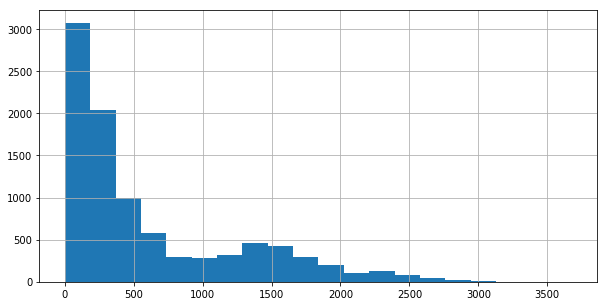

In [92]:
objects_processed.first_review_diff.hist(figsize=(10,5),bins=20)

In [144]:
objects_processed.first_review_diff = pd.cut(objects_processed.first_review_diff, bins=[0, 500, 10000], labels=['<=500', '>500'], right=False)
objects_processed.first_review_diff = objects_processed.first_review_diff.cat.add_categories(['unknown'])
objects_processed.first_review_diff.fillna('unknown',inplace=True)


In [145]:
objects_processed.first_review_diff.value_counts(normalize=True)

unknown    0.526182
<=500      0.300400
>500       0.173417
Name: first_review_diff, dtype: float64

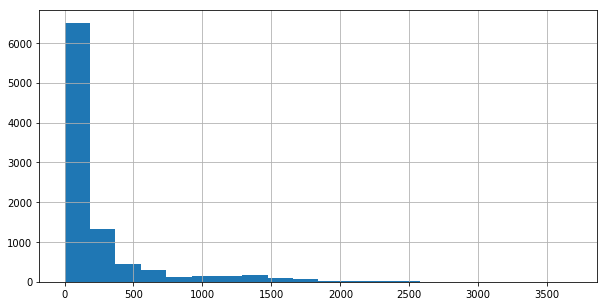

In [95]:
objects_processed.last_review_diff.hist(figsize=(10,5),bins=20)

In [146]:
objects_processed.last_review_diff = pd.cut(objects_processed.last_review_diff, bins=[0, 50, 10000], labels=['<=50', '>50'], right=False)
objects_processed.last_review_diff = objects_processed.last_review_diff.cat.add_categories(['unknown'])
objects_processed.last_review_diff.fillna('unknown',inplace=True)


In [147]:
objects_processed.last_review_diff.value_counts(normalize=True)

unknown    0.526182
>50        0.258275
<=50       0.215542
Name: last_review_diff, dtype: float64

We can fill NaN values with median ones for `host_since_diff` and `host_listings_count`.

In [98]:
print(len(objects_processed[objects_processed.host_since_diff.isnull()]))
print(len(objects_processed[objects_processed.host_listings_count.isnull()]))

27
27


In [148]:
median_cols = ['host_listings_count','host_since_diff']
    
for column in median_cols:
    median_value=objects_processed[column].median()
    objects_processed[column]=objects_processed[column].fillna(median_value)
    

For review columns, I suspect there might be correlation within these columns. Let's check this correlation first.

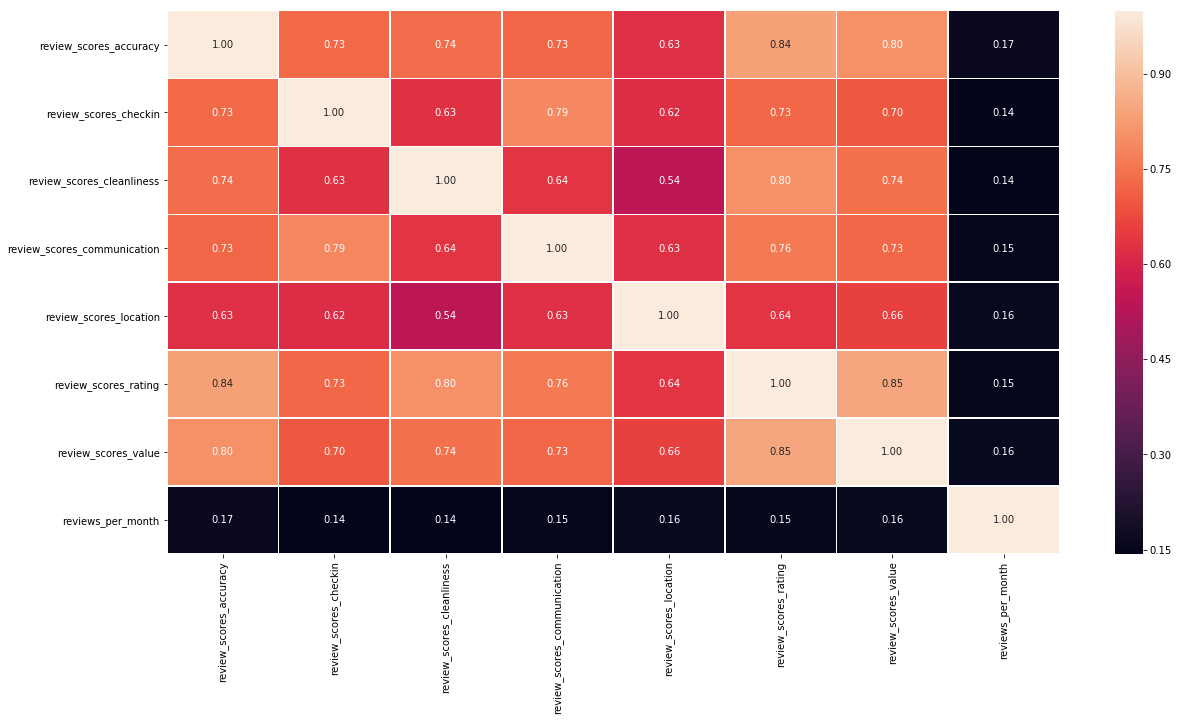

In [100]:
reviews = ['review_scores_accuracy','review_scores_checkin','review_scores_cleanliness','review_scores_communication','review_scores_location','review_scores_rating','review_scores_value','reviews_per_month']

plt.figure(figsize = (20,10))
sns.heatmap(objects_processed[reviews].corr(), annot=True, fmt='.2f', linewidths=.8) 



I'm gonna remove the columns that have over 79% correlation.

`review_scores_rating` is highly correlated with `'review_scores_accuracy','review_scores_cleanliness','review_scores_value'`.

And, `review_scores_communication` is highly correlated with `'review_scores_checkin'`



In [149]:
drop_revs = ['review_scores_accuracy','review_scores_cleanliness','review_scores_value','review_scores_checkin']

objects_processed.drop(drop_revs,axis=1,inplace=True)


For the rest, we can do category conversion as we did for the `'first_review_diff','last_review_diff'` since NaN values are also important for these columns: `'review_scores_communication','review_scores_location','review_scores_rating','reviews_per_month'`.


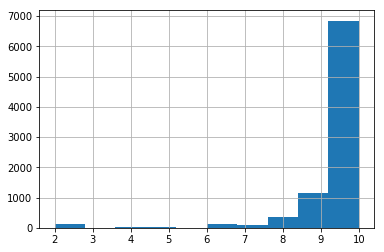

In [117]:
objects_processed.review_scores_communication.hist()

In [150]:
objects_processed.review_scores_communication = pd.cut(objects_processed.review_scores_communication, bins=[0, 10, 1000], labels=['<10', '10'], right=False)
objects_processed.review_scores_communication = objects_processed.review_scores_communication.cat.add_categories(['unknown'])
objects_processed.review_scores_communication.fillna('unknown',inplace=True)


In [151]:
objects_processed.review_scores_communication.value_counts(normalize=True)

unknown    0.554367
10         0.347138
<10        0.098494
Name: review_scores_communication, dtype: float64

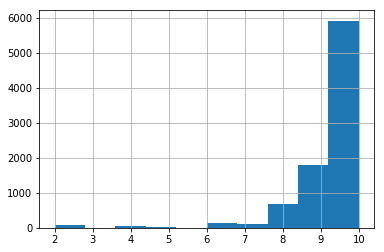

In [121]:
objects_processed.review_scores_location.hist()

In [152]:
objects_processed.review_scores_location = pd.cut(objects_processed.review_scores_location, bins=[0, 10, 1000], labels=['<10', '10'], right=False)
objects_processed.review_scores_location = objects_processed.review_scores_location.cat.add_categories(['unknown'])
objects_processed.review_scores_location.fillna('unknown',inplace=True)


In [123]:
objects_processed.review_scores_location.value_counts(normalize=True)

unknown    0.554671
10         0.299894
<10        0.145435
Name: review_scores_location, dtype: float64

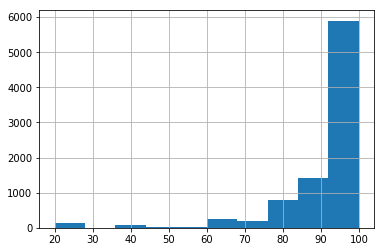

In [124]:
objects_processed.review_scores_rating.hist()

In [153]:
objects_processed.review_scores_rating = pd.cut(objects_processed.review_scores_rating, bins=[0, 90, 1000], labels=['<90', '90-100'], right=False)
objects_processed.review_scores_rating = objects_processed.review_scores_rating.cat.add_categories(['unknown'])
objects_processed.review_scores_rating.fillna('unknown',inplace=True)


In [154]:
objects_processed.review_scores_rating.value_counts(normalize=True)

unknown    0.553962
90-100     0.333350
<90        0.112688
Name: review_scores_rating, dtype: float64

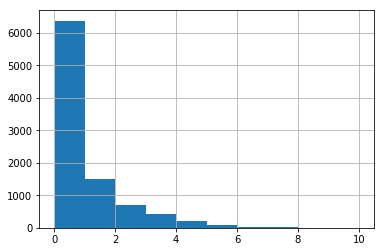

In [127]:
objects_processed.reviews_per_month.hist()

In [155]:
objects_processed.reviews_per_month = pd.cut(objects_processed.reviews_per_month, bins=[0, 1, 100], labels=['<1', '1-10'], right=False)
objects_processed.reviews_per_month = objects_processed.reviews_per_month.cat.add_categories(['unknown'])
objects_processed.reviews_per_month.fillna('unknown',inplace=True)


In [156]:
objects_processed.reviews_per_month.value_counts(normalize=True)

unknown    0.526182
<1         0.298271
1-10       0.175546
Name: reviews_per_month, dtype: float64

In [190]:
processed_listings = objects_processed.copy()

Now, we've cleaned all the NaN values, and we can check the statistical distributions for each column.

In [158]:
processed_listings.describe()

,host_is_superhost,host_listings_count,host_identity_verified,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,maximum_minimum_nights,minimum_maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,instant_bookable,Pets allowed,Bed linens,Wifi,Dryer,Laptop friendly workspace,Kitchen,Luggage dropoff allowed,Washer,Free parking on premises,Fire extinguisher,Hot water,TV,Refrigerator,Heating,Smoke detector,First aid kit,Carbon monoxide detector,Iron,Hair dryer,Hangers,Shampoo,Host greets you,Internet,Elevator,Cooking basics,Breakfast,Essentials,Smoking allowed,Long term stays allowed,Cable TV,Family/kid friendly,Lock on bedroom door,Air conditioning,host_since_diff
count,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,1.972700e+04,19727.000000,1.972700e+04,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.00000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000
mean,0.076393,14.309576,0.190298,41.027520,28.984211,0.315253,3.105084,1.187966,1.354844,2.013585,377.366706,231.105338,45.284635,1.392508,28.110407,4.335885,1.098158e+05,4.593501,1.098156e+05,20.411872,43.538754,68.214376,243.167942,7.257616,3.631520,0.561768,0.253003,0.224058,0.926497,0.31723,0.671161,0.849698,0.225022,0.733614,0.273483,0.381812,0.490647,0.773965,0.254676,0.921732,0.330359,0.316521,0.205809,0.694936,0.764688,0.757997,0.753181,0.231105,0.217316,0.343793,0.212399,0.205049,0.897197,0.480965,0.232220,0.239722,0.267400,0.427029,0.519542,1126.430375
std,0.265632,108.425903,0.392546,0.043559,0.118671,0.464628,2.222619,0.901195,1.407388,2.074018,1291.115797,1273.113740,108.414052,1.097863,61.834418,26.246753,1.528971e+07,28.135452,1.528971e+07,11.691232,21.897423,31.058530,135.189250,22.274279,9.969259,0.496183,0.434744,0.416971,0.260967,0.46541,0.469803,0.357376,0.417607,0.442080,0.445758,0.485843,0.499925,0.418273,0.435690,0.268600,0.470354,0.465130,0.404302,0.460446,0.424204,0.428307,0.431171,0.421550,0.412430,0.474985,0.409016,0.403748,0.303709,0.499650,0.422259,0.426925,0.442614,0.494659,0.499631,817.006423
min,0.000000,0.000000,0.000000,40.813280,28.032000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000e+00,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,0.000000,41.004830,28.973640,0.000000,2.000000,1.000000,1.000000,1.000000,116.000000,0.000000,0.000000,1.000000,0.000000,1.000000,6.000000e+01,1.000000,6.000000e+01,10.000000,29.000000,56.000000,99.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,335.000000
50%,0.000000,2.000000,0.000000,41.031740,28.984040,0.000000,2.000000,1.000000,1.000000,1.000000,208.00000

In [159]:
numerical_columns = list(set(processed_listings.columns) - set(amenities_columns))

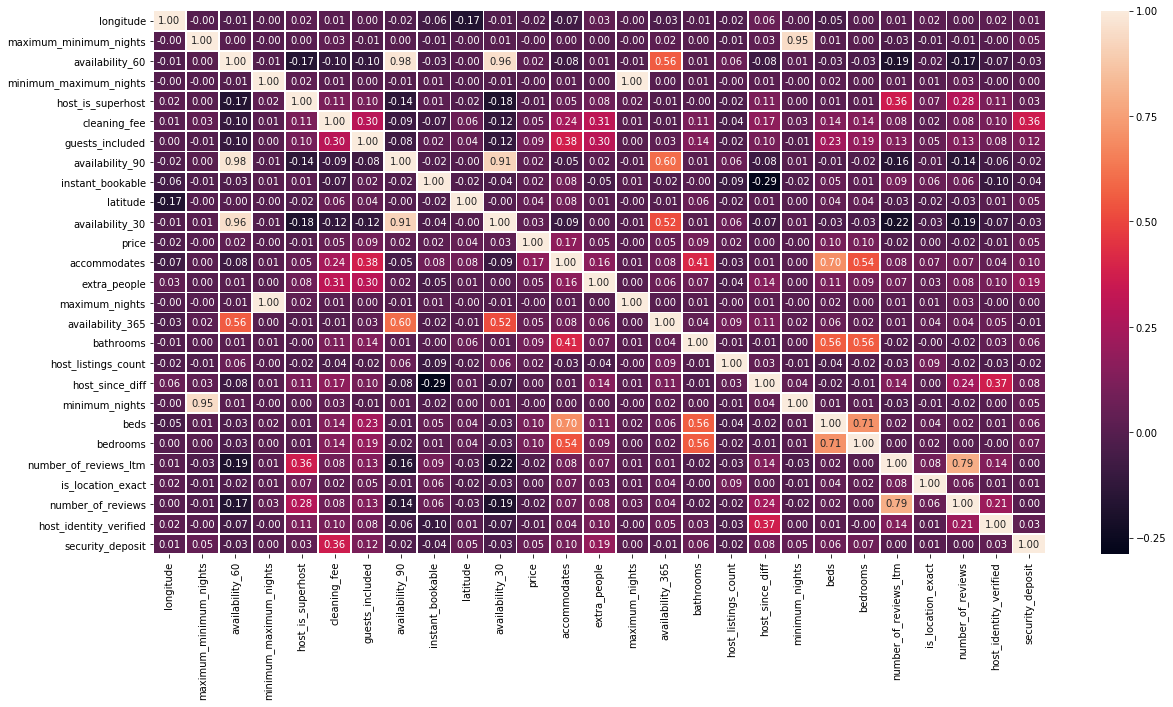

In [160]:
plt.figure(figsize = (20,10))
sns.heatmap(processed_listings[numerical_columns].corr(), annot=True, fmt='.2f', linewidths=.8)


Seems like for availabilities, we can just keep one of them, I'm gonna keep `availability_30`,
for number of reviews I'm gonna keep `number_of_reviews`, and for min/max nights I'm gonna keep `minimum_nights` & `maximum_nights`.


In [191]:
processed_listings.drop(['availability_60','availability_90'],axis=1,inplace=True)
processed_listings.drop('number_of_reviews_ltm',axis=1,inplace=True)
processed_listings.drop(['minimum_maximum_nights','maximum_minimum_nights'],axis=1,inplace=True)


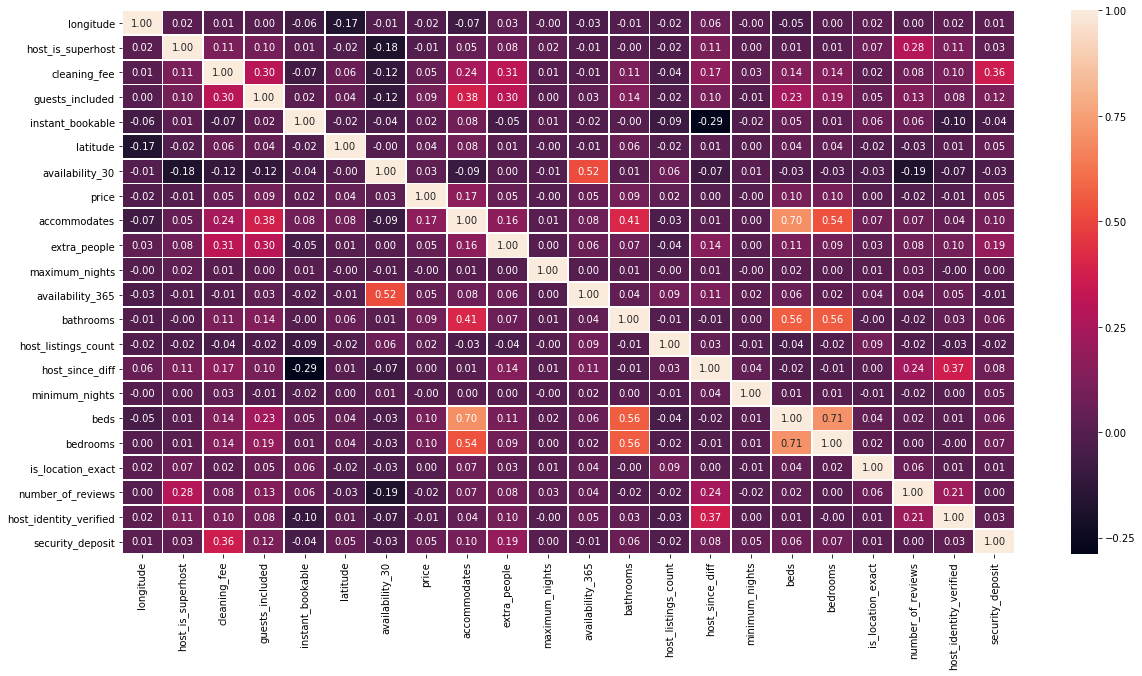

In [162]:
cols = list(set(numerical_columns) - set(['availability_60','availability_90','minimum_maximum_nights','maximum_minimum_nights','number_of_reviews_ltm']))
plt.figure(figsize = (20,10))
sns.heatmap(processed_listings[cols].corr(), annot=True, fmt='.2f', linewidths=.8)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x128a974a8>,
      dtype=object)

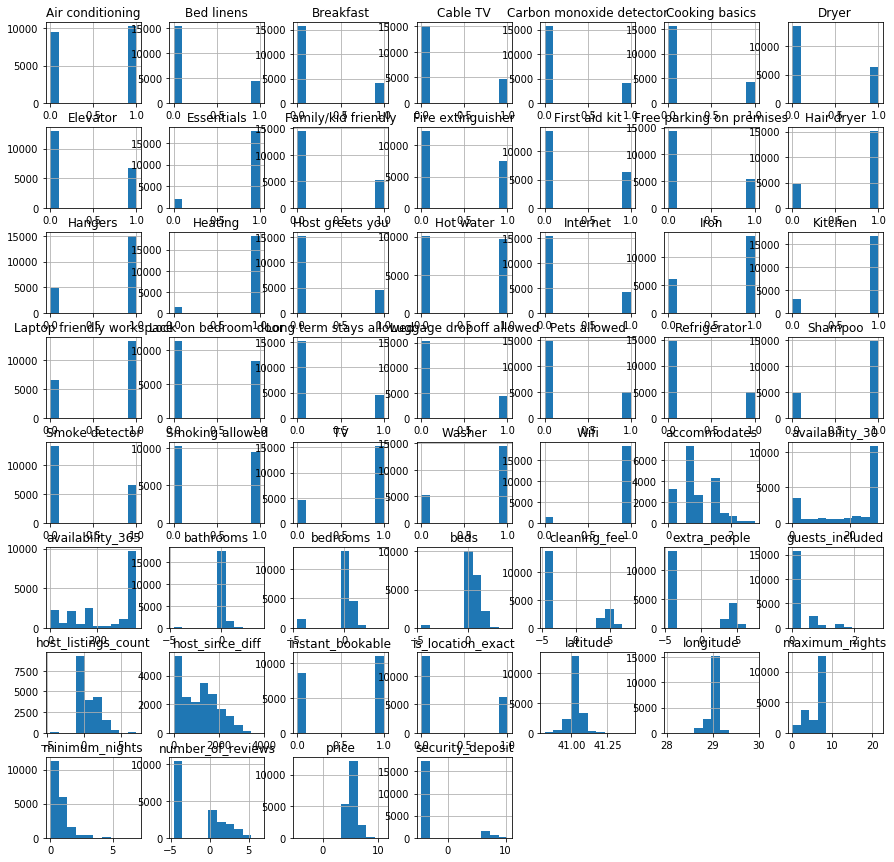

In [171]:
processed_listings.hist(figsize=(15,15))

Seems like some columns mostly have same values.

In [180]:
processed_listings['Kitchen'].value_counts(normalize=True)

1.0    0.849698
0.0    0.150302
Name: Kitchen, dtype: float64

In [192]:
processed_listings.drop('Wifi',axis=1,inplace=True)
processed_listings.drop('Kitchen',axis=1,inplace=True)
processed_listings.drop('Essentials',axis=1,inplace=True)
processed_listings.drop('Heating',axis=1,inplace=True)
processed_listings.drop('host_is_superhost',axis=1,inplace=True)
processed_listings.drop('host_identity_verified',axis=1,inplace=True)


Our target variable `price` seems to have outlier values.

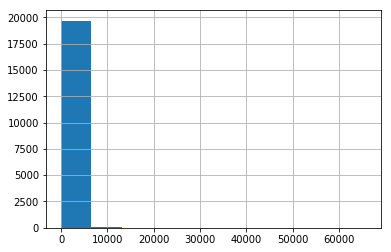

In [193]:
processed_listings.price.hist()

In [194]:
processed_listings.price.describe()

count    19727.000000
mean       377.366706
std       1291.115797
min          0.000000
25%        116.000000
50%        208.000000
75%        381.000000
max      65726.000000
Name: price, dtype: float64

In [198]:
processed_listings[processed_listings.price > 10000]

,host_response_time,host_response_rate,host_listings_count,neighbourhood_cleansed,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_365,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location,instant_bookable,cancellation_policy,reviews_per_month,Pets allowed,Bed linens,Dryer,Laptop friendly workspace,Luggage dropoff allowed,Washer,Free parking on premises,Fire extinguisher,Hot water,TV,Refrigerator,Smoke detector,First aid kit,Carbon monoxide detector,Iron,Hair dryer,Hangers,Shampoo,Host greets you,Internet,Elevator,Cooking basics,Breakfast,Smoking allowed,Long term stays allowed,Cable TV,Family/kid friendly,Lock on bedroom door,Air conditioning,last_review_diff,host_since_diff,first_review_diff
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1768486,within an hour,100%,17.0,Fatih,41.00574,28.96820,1,Apartment,Entire home/apt,4,1.0,1.0,2.0,26547,0.0,0.0,2,33,3,1125,30,365,3,<90,<10,10,0,strict,<1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,>50,2620.0,>500
3317004,a few days or more,unknown,1.0,Fatih,41.00615,28.96455,0,Apartment,Private room,2,1.0,1.0,2.0,16434,0.0,0.0,1,0,1,1125,29,364,0,unknown,unknown,unknown,0,moderate,unknown,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,unknown,1842.0,unknown
11017596,a few days or more,unknown,2.0,Sisli,41.07317,29.01314,0,Apartment,Entire home/apt,3,3.0,3.0,3.0,19717,0.0,0.0,1,0,1,1125,30,365,0,unknown,unknown,unknown,0,flexible,unknown,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,unknown,2511.0,unknown
11406502,a few days or more,unknown,1.0,Uskudar,41.01163,29.01606,1,Apartment,Private room,1,1.0,1.0,1.0,19717,0.0,0.0,1,0,30,365,30,365,0,unknown,unknown,unknown,0,flexible,unknown,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,unknown,1223.0,unknown
13567253,a few days or more,unknown,2.0,Sisli,41.04695,28.98709,0,Hotel,Private room,2,1.0,1.0,1.0,13141,0.0,0.0,2,33,5,1125,27,362,0,unknown,unknown,unknown,1,flexible,unknown,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,unknown,1107.0,unknown
13703737,a few days or more,unknown,1.0,Sisli,41.05709,28.98525,0,Apartment,Private room,2,1.0,1.0,2.0,28893,0.0,289.0,1,116,1,1125,29,364,0,unknown,unknown,unknown,0,strict,unknown,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,unknown,2519.0,unknown
13890710,a few days or more,unknown,1.0,Beyoglu,41.03705,28.98109,0,Apartment,Entire home/apt,4,1.0,2.0,2.0,13146,0.0,0.0,2,1643,1,1125,30,365,0,unknown,unknown,unknown,0,flexible,unknown,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,unknown,1096.0,unknown
19376687,a few days or more,unknown,1.0,Bagcilar,41.05329,28.82745,0,Apartment,Entire home/apt,11,8.0,6.0,10.0,11557,0.0,0.0,1,0,1,1,30,180,0,unknown,unknown,unknown,0,flexible,unknown,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,unknown,788.0,unknown
20275354,a few days or more,unknown,1.0,Sisli,41.05465,28.98111,0,Apartment,Private room,1,1.0,1.0,1.0,53897,0.0,0.0,1,0,2,1125,0,0,0,unknown,unknown,unknown,1,flexible,unknown,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,unknown,850.0,unknown


We can remove these outlier values.

In [199]:
processed_listings = processed_listings[processed_listings.price <= 10000]

From the above histograms, there are many skewed distributions. For these columns log transformation might help to the algorithm success.

In [200]:
log_columns = ['accommodates','bathrooms','bedrooms','beds','cleaning_fee','extra_people','guests_included','host_listings_count','maximum_nights','minimum_nights','number_of_reviews','price','security_deposit']

for column in log_columns:
    processed_listings[column] = processed_listings[column].astype('float64').replace(0.0, 0.01)
    processed_listings[column] = np.log(processed_listings[column])
    

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12d3af780>,
      dtype=object)

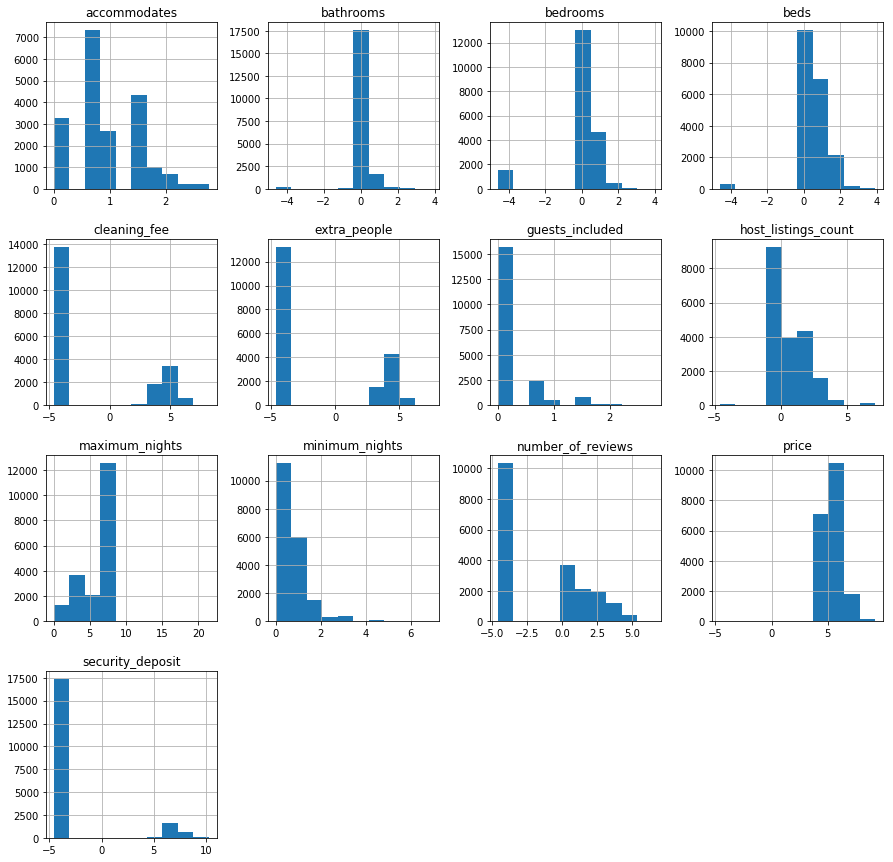

In [201]:
processed_listings[log_columns].hist(figsize=(15,15))

### ML

For multi categorical columns, get_dummies method can handle most of them to convert them into the numerical values, but for some of them manual analysis and extraction should be made. See below operations.

In [202]:
features = processed_listings.drop('price',axis=1)
y = processed_listings['price']

In [203]:
scaler = StandardScaler()
numerical_columns = features.columns[(features.dtypes != 'object') & (features.dtypes != 'category')]
features[numerical_columns] = scaler.fit_transform(features[numerical_columns])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [204]:
dummied_items = pd.get_dummies(features,dummy_na=True)

In [205]:
X_train, X_test, y_train, y_test = train_test_split(dummied_items,y,test_size=0.30,random_state=0)

In [214]:
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)
linear_regression.score(X_train,y_train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


0.5301430260201817

In [206]:
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
knn.score(X_train, y_train)

0.634110460046068

In [207]:
gbr = GradientBoostingRegressor(random_state=0)
gbr.fit(X_train, y_train)
gbr.score(X_train, y_train)

0.6125109333264407

In [208]:
def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Creat the plot
    fig = plt.figure(figsize = (9,5))
    plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(5), columns)
    plt.xlim((-0.5, 4.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show() 

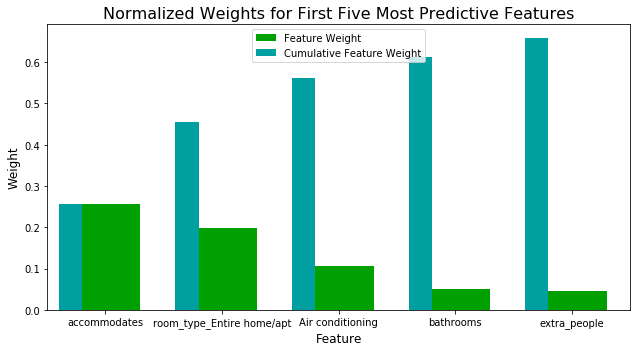

In [209]:
importances = gbr.feature_importances_
feature_plot(importances, X_train, y_train)

In [210]:
tree = DecisionTreeRegressor(random_state=0)
tree.fit(X_train, y_train)
tree.score(X_train, y_train)

1.0

In [212]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]


In [213]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
xgb_reg.score(X_train, y_train)

0.6104379172361012

knn or gradient boosting seems to produce meaningful results. Desicion tree is probably overfitting. To improve this, we need to complete feature preprocessing thoroughly and maybe try tunning hyperparameters for the algorithm.

TBC